In [1]:
import math
import time
import pickle
from multiprocessing import Pool, TimeoutError

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tqdm
from random import random, randint
from IPython.display import clear_output
from nfa_lib import NFA, count_nfa, random_matrix_for_nfa

sns.set()


In [2]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}, '1': {'q3'}},
        'q1': {'0': {'q2'}},
        'q2': {'0': {'q0'}, '1': {'q3'}},
        'q3': {'0': {'q4'}},
        'q4': {'0': {'q5'}},
        'q5': {'0': {'q3'}},
        'q6': {'1': {'q4'}},
    },
    initial_states={'q0', 'q1', 'q5', 'q6'},
    final_states={'q2', 'q4', 'q6'}
)

In [3]:
nfa.cycle_height()

2

In [8]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1', 'q2'}},
        'q1': {'0': {'q1', 'q3'}},
        'q2': {'0': {'q3'}, '1': {'q2'} },
        'q3': {'0': {'q3'}},
    },
    initial_states={'q0'},
    final_states={'q3'}
)

In [ ]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        'q1': {'1': {'q2'}},
        'q2': {'1': {'q0'}}
    },
    initial_states={'q0'},
    final_states={'q1'}
)

In [13]:
%%time
nfa.bruteforce_count_only(20)

100%|██████████| 1048576/1048576 [00:06<00:00, 166056.87it/s]

CPU times: user 6.32 s, sys: 15.8 ms, total: 6.33 s
Wall time: 6.32 s


8

In [ ]:
nfa.plot()

In [ ]:
count, nfa_unroll = count_nfa(nfa, 55, 1500)
count

In [ ]:
x = np.array([1.,2.,3.])


In [ ]:
print(nfa.plot().source)
nfa.plot()

# Experimentos estadísticos

In [ ]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        # Use '' as the key name for empty string (lambda/epsilon) transitions
        'q1': {
            #'0': {'q1'},
            '1': {'q0', 'q2'}},
        'q2': {
            '1': {'q0'}
        }
    },
    initial_states={'q0'},
    final_states={'q1'}
)

In [36]:
%%time
data = [(i,nfa.bruteforce_count_only(i)) for i in range(1, 20)]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/32768 [00:00<?, ?it/s]

  0%|          | 0/65536 [00:00<?, ?it/s]

  0%|          | 0/131072 [00:00<?, ?it/s]

  0%|          | 0/262144 [00:00<?, ?it/s]

  0%|          | 0/524288 [00:00<?, ?it/s]

CPU times: user 6.16 s, sys: 44.6 ms, total: 6.21 s
Wall time: 6.17 s


In [ ]:
log_data = [(i, math.log(max(1, nfa.bruteforce_count_only(i)))) for i in range(1, 20)]

In [37]:
df_count = pd.DataFrame(data, columns=["i", "frac"])

<AxesSubplot:xlabel='i'>

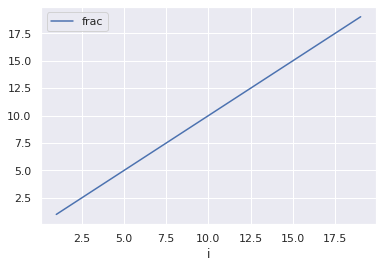

In [38]:
df_count.plot(x="i", y="frac")

In [39]:
df_count

,i,frac
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5
5,6,6
6,7,7
7,8,8
8,9,9
9,10,10


In [ ]:
df[df.i >= 5].plot(x="i", y="frac")

In [ ]:
def fit_function(x, a, b, c):
    return a*b**(c*x)

In [ ]:
predictable_data = df[df.i.between(11,23)]

In [ ]:
x_data = predictable_data.i.values
y_data = predictable_data.frac.values
popt, pcov = scipy.optimize.curve_fit(fit_function, x_data, y_data, maxfev=1000)

In [ ]:
all_data = df[df.i >= 5]
all_x_data = all_data.i.values
all_y_data = all_data.frac.values

fig = plt.plot(all_x_data, fit_function(all_x_data, *popt), label="fit")
plt.plot(all_x_data, all_y_data, label="real")
plt.legend();
plt.title("Comparación valores predichos y reales")
plt.gcf().set_size_inches((14,8))

In [ ]:
plt.plot(all_x_data, fit_function(all_x_data, *popt) - all_y_data, label="fit")
plt.legend();
plt.title("Residuos")
plt.gcf().set_size_inches((14,8))

In [ ]:
k = 28
pred_for_k = fit_function(k, *popt) * 2**k
pred_for_k

In [ ]:
[(k,int(fit_function(k, *popt) * 2**k)) for k in range(6,28)]

In [ ]:
{{6, 13},
 {7, 23},
 {8, 44},
 {9, 81},
 {10, 148},
 {11, 274},
 {12, 504},
 {13, 927},
 {14, 1705}}

In [ ]:
%%time
ground_truth_k = nfa.bruteforce_dfs(k)
ground_truth_k

In [ ]:
popt

In [ ]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

In [ ]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

- https://arxiv.org/pdf/1802.04708.pdf -> si A es acíclico, el lenguaje es finito. De hecho, $L(A) \subseteq (\Sigma \cup \{\epsilon\})^{|Q|}$
- En general, para $n < |Q|$ el comportamiento se puede hardcodear, por lo que fuerza bruta o `sketch` son necesarios
- http://www.stringology.org/cgi-bin/getfile.cgi?t=pdf&c=-&y=2013&n=03 -> hay un algoritmo $O(|Q|)$ que usa `BFS` y `gcd` para determinar si la densidad del lenguaje es exponencial o polinomial. Se basa en encontrar dos caminos distintos del mismo largo y estado de partida en una componente fuertemente conexa (SCC).
    - Hipótesis 1: si el lenguaje tiene densidad exponencial, el gráfico $|L_n(A)|/2^n$ se verá como una constante tras al menos $n=|Q|$. Estimar es trivial para $n \gg |Q|$, basta retornar esa proporción multiplicada por $2^n$
    - Hipótesis 2: si el lenguaje tiene densidad polinomial, el gráfico $|L_n(A)|/2^n$ se verá como una exponencial
    decayendo. Se puede fittear una función y aproximar para $n \gg |Q|$
    
- [Scholar Kai Salomaa](https://scholar.google.com/citations?hl=es&user=N3AlqdYAAAAJ&view_op=list_works&sortby=pubdate)

Keeler, Salomaa


$|L(A)| \le \text{ambiguity} \le \text{string path width} \le \text{tree width}$

- **ambiguity**: number of accepting computations of A on a given string
- **string path width**: does not count partial computations, only complete (and maybe non-accepting) computations
- **tree width**: all computations of A on a given string (even partial ones)

In [ ]:
np.random.choice(["-1","0","1"], size=(3,3))[1,0]

In [ ]:
rand = NFA.random(n_states=5, input_symbols={"0", "1"}, sparsity=0.5)
rand.plot()

In [ ]:
rand.bruteforce_count_only(15)

In [ ]:
count, nfa_unroll = count_nfa(rand, 15, 100)
count

In [ ]:
with open("intermediate_stats.pkl", "rb") as fd:
    results_stats = pickle.load(fd)
        
df = pd.DataFrame(results_stats, columns=["n_states", "initial_states", "final_states", "transitions",
                                    "string_n", "bruteforce", "estimate", "eps", "time"])
df["rel_error"] = abs(df.estimate - df.bruteforce)/df.bruteforce

In [48]:
def instantiate_nfa(df_row):
    states = {f"q{i}" for i in range(df_row.n_states)}
    nfa = NFA(
        states=states,
        initial_states=df_row.initial_states,
        final_states=df_row.final_states,
        input_symbols={"0", "1"},
        transitions=df_row.transitions,
    )
    return nfa

In [2]:
with open("random_nfa_from_matrices.pkl", "rb") as fd:
    data = pickle.load(fd)
df = pd.DataFrame(data)
df["density"] = df.accepted_counts.map(lambda x: [xi / 2**i for i,xi in enumerate(x, 1)])
df["last_density"] = df.density.map(lambda x: x[-1])
df["last_count"] = df.accepted_counts.map(lambda x: x[-1])
df["probably_exp"] = df.density.map(lambda x: (x[-2] - x[-1]) < 1e-6 and x[-1] > 0)
df["n_states"] = df.matrix.map(lambda m: m.shape[1])
df["count_hash"] = df.accepted_counts.map(lambda c: hash(tuple(c)))
df["real_n_states"] = df.matrix.map(lambda m: len(NFA.from_random_matrix(m).states))
df["height"] = df.matrix.map(lambda m: NFA.from_random_matrix(m).cycle_height())

In [4]:
[len(df[df.real_n_states == i].count_hash.unique()) / df[df.real_n_states == i].shape[0] for i in range(2,15)]

[0.007576840600428878,
 0.09079861111111111,
 0.16568483063328424,
 0.22652757078986588,
 0.24353690520794305,
 0.2340026271345468,
 0.22513287775246774,
 0.21029082774049218,
 0.17825513472771812,
 0.15645857872006283,
 0.13339920948616601,
 0.09787928221859707,
 0.0541922290388548]

In [8]:
df.height.value_counts()

inf    57420
0.0    13835
1.0     6856
2.0      289
Name: height, dtype: int64

<AxesSubplot:>

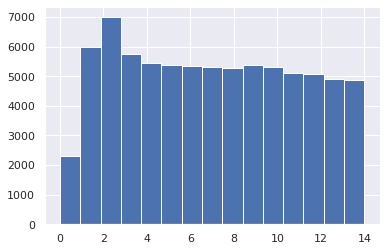

In [18]:
df.real_n_states.hist(bins=15)

# Aceptan la secuencia de Fibonacci !!!

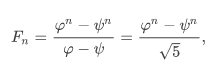

Es asintótica a 

In [7]:
df[df.last_count.isin([1597, 610, 987])]

,sparsity,matrix,accepted_counts,height,density,last_density,last_count,probably_exp,n_states,count_hash,real_n_states
24,0.620606,"[[0, 1], [0, 1], [0, 0], [1, 0], [1, 1], [1, 1]]","[2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377...",inf,"[1.0, 0.75, 0.625, 0.5, 0.40625, 0.328125, 0.2...",0.048737,1597,False,2,-8133805471270946259,2
38,0.684600,"[[0, 0, 0], [0, 0, 1], [0, 0, 0], [0, 0, 0], [...","[2, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 23...",inf,"[1.0, 0.25, 0.25, 0.1875, 0.15625, 0.125, 0.10...",0.018616,610,False,3,-4056193983456361400,3
62,0.752865,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, ...",inf,"[0.5, 0.5, 0.375, 0.3125, 0.25, 0.203125, 0.16...",0.030121,987,False,10,-926768237329163453,10
184,0.678500,"[[1, 1], [0, 0], [0, 0], [1, 0], [1, 0], [0, 1]]","[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 23...",inf,"[0.5, 0.25, 0.25, 0.1875, 0.15625, 0.125, 0.10...",0.018616,610,False,2,-4359924220400588251,2
380,0.826572,"[[1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 1...","[2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377...",inf,"[1.0, 0.75, 0.625, 0.5, 0.40625, 0.328125, 0.2...",0.048737,1597,False,5,-8133805471270946259,5
...,...,...,...,...,...,...,...,...,...,...,...
78070,0.881255,"[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0...","[2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377...",inf,"[1.0, 0.75, 0.625, 0.5, 0.40625, 0.328125, 0.2...",0.048737,1597,False,6,-8133805471270946259,6
78117,0.702504,"[[1, 0, 0, 1, 1], [0, 0, 0, 1, 0], [0, 0, 0, 0...","[2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377...",inf,"[1.0, 0.75, 0.625, 0.5, 0.40625, 0.328125, 0.2...",0.048737,1597,False,5,-8133805471270946259,4
78143,0.663363,"[[1, 0, 0, 1, 1], [0, 0, 0, 1, 0], [0, 0, 0, 0...","[2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377...",inf,"[1.0, 0.75, 0.625, 0.5, 0.40625, 0.328125, 0.2...",0.048737,1597,False,5,-8133805471270946259,4
78144,0.543573,"[[0, 0], [1, 0], [0, 1], [0, 1], [1, 1], [1, 0]]","[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 23...",inf,"[0.5, 0.25, 0.25, 0.1875, 0.15625, 0.125, 0.10...",0.018616,610,False,2,-4359924220400588251,2


In [3]:
fibs = df[df.last_count.isin([1597, 610, 987])]
fibs[fibs.n_states == 14].matrix.map(lambda x: x.sum()).value_counts()

35    1
57    1
61    1
Name: matrix, dtype: int64

In [33]:
fibs[fibs.height == 1]

,sparsity,matrix,accepted_counts,height,density,last_density,last_count,probably_exp,n_states,count_hash,real_n_states
12219,0.808876,"[[0, 0, 0, 1], [0, 0, 0, 0], [1, 0, 0, 0], [0,...","[1, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377...",1.0,"[0.5, 0.75, 0.625, 0.5, 0.40625, 0.328125, 0.2...",0.048737,1597,False,4,8631950600685200787,3
23659,0.593906,"[[0, 1, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 23...",1.0,"[0.5, 0.25, 0.25, 0.1875, 0.15625, 0.125, 0.10...",0.018616,610,False,4,-4359924220400588251,3
25710,0.730349,"[[0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [1,...","[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, ...",1.0,"[0.5, 0.5, 0.375, 0.3125, 0.25, 0.203125, 0.16...",0.030121,987,False,4,-926768237329163453,2
33832,0.624263,"[[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1,...","[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, ...",1.0,"[0.5, 0.5, 0.375, 0.3125, 0.25, 0.203125, 0.16...",0.030121,987,False,4,-926768237329163453,2
39511,0.924436,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 1, ...","[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 23...",1.0,"[0.5, 0.25, 0.25, 0.1875, 0.15625, 0.125, 0.10...",0.018616,610,False,12,-4359924220400588251,3
55894,0.782076,"[[0, 0, 0, 0, 1], [0, 0, 1, 0, 1], [0, 1, 0, 0...","[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 23...",1.0,"[0.5, 0.25, 0.25, 0.1875, 0.15625, 0.125, 0.10...",0.018616,610,False,5,-4359924220400588251,2
57506,0.768608,"[[1, 1, 0, 1], [1, 0, 0, 1], [0, 0, 0, 1], [0,...","[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 23...",1.0,"[0.5, 0.25, 0.25, 0.1875, 0.15625, 0.125, 0.10...",0.018616,610,False,4,-4359924220400588251,2
63011,0.881328,"[[0, 0, 1, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[1, 0, 1, 2, 2, 5, 8, 13, 24, 40, 69, 120, 205...",1.0,"[0.5, 0.0, 0.125, 0.125, 0.0625, 0.078125, 0.0...",0.018616,610,False,7,-5170783928966892074,3


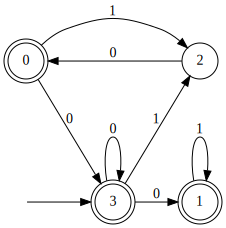

In [13]:
nfa = NFA.from_random_matrix(df.loc[12219].matrix)
nfa.plot()

In [3]:
df_dedup = df.drop_duplicates(subset=["count_hash"])
df_dedup.shape

(8320, 11)

<AxesSubplot:>

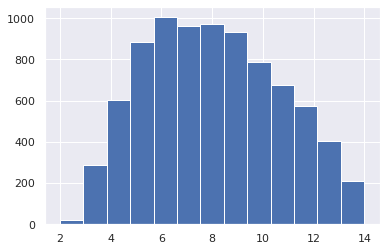

In [19]:
df_dedup.real_n_states.hist(bins=13)

In [13]:
timeout = 600
def compare_random_to_brute(i, nfa: NFA)->list:
    print(f"[{i}] started\n", end="")
    ret_data = []
    start = time.time()
    for string_len in range(3, 10):
        bruteforce = nfa.bruteforce_count_only(string_len)
        if bruteforce == 0:
            continue
        k_mult_base = 1
        max_k_mult = 8
        while k_mult_base < max_k_mult:
            k_mult = 2 ** k_mult_base
            try:
                t0 = time.time()
                # Runaway: less than 10 seconds left
                if (t0 - start) > (timeout - 10):
                    continue
                count, nfa_unroll = count_nfa(nfa, string_len, eps=1, kappa_multiple=k_mult)
                t1 = time.time()
                ret_data.append({
                    "n_states": len(nfa.states),
                    "states": nfa.states,
                    "initial_states": nfa.initial_states,
                    "final_states": nfa.final_states,
                    "transitions": nfa.transitions,
                    "string_len": string_len,
                    "bruteforce": bruteforce,
                    "estimate": count,
                    "kappa_multiple": k_mult,
                    "time": t1 - t0,
                })
                rel_error = (count - bruteforce) / bruteforce
                # if low rel_error or the next round will probably take more than remaining time
                remaining_time = timeout - (t1 - start)
                if rel_error < 0.5 or 2 * (t1 - t0) > remaining_time:
                    break
                k_mult_base += 1
            except ValueError as e:
                k_mult_base += 1
                print(f"Insufficient {k_mult=} at index {i=}")
                if k_mult_base == max_k_mult:
                    return e
            except Exception as e:
                return e
    return ret_data


results = [] # n_states, initial_states, final_states, transitions, string_n, bruteforce, estimate, eps, time
samples = 0
errors = []
error_count = 0
n_proc = 6
offset = 4
with Pool(processes=n_proc) as pool:
    # sorted_nfas = df.sort_values(by="rel_error", ascending=True).tail(250).head(100)
    # sorted_nfas = df_kappa[df_kappa.kappa_multiple == 256]
    sorted_nfas = df_dedup[df_dedup.real_n_states.between(2,5)]
    while offset < sorted_nfas.shape[0] and error_count < 3:
        nfa_subset = [NFA.from_random_matrix(row.matrix) for row in 
                      sorted_nfas.iloc[offset:offset+10].itertuples()]
        multiproc_results = [pool.apply_async(compare_random_to_brute, (i, nfa)) 
                             for i, nfa in enumerate(nfa_subset)]
        for res_promise in tqdm(multiproc_results):
            res = None
            try:
                res = res_promise.get(timeout=timeout)
            except TimeoutError:
                continue

            if isinstance(res, Exception):
                errors.append(res)
                error_count += 1
                continue
            else:
                samples += 1
                
                results.extend(res)
            offset += 1

        clear_output(wait=True)
        with open("randomized_algo_on_2_to_5.pkl", "wb") as fd:
            pickle.dump(results, fd)
        print(f"Wrote pickle file for {len(results)} results")


Wrote pickle file for 127 results


  0%|          | 0/10 [00:00<?, ?it/s]

Process ForkPoolWorker-22:
Process ForkPoolWorker-21:
Process ForkPoolWorker-25:
Process ForkPoolWorker-24:
Process ForkPoolWorker-23:
Process ForkPoolWorker-26:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

In [14]:
len(results)

127

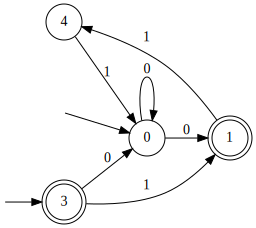

In [5]:
nfa = NFA.from_random_matrix(sorted_nfas.iloc[2].matrix)
nfa.plot()

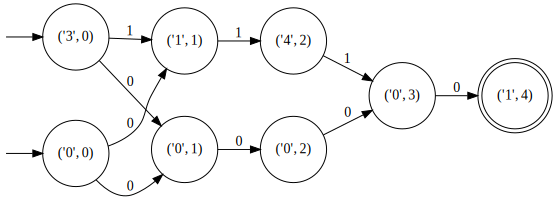

In [6]:
nfa.unroll(4).plot()

In [7]:
nfa.unroll(4).__dict__

{'states': {('0', 0),
  ('0', 1),
  ('0', 2),
  ('0', 3),
  ('1', 1),
  ('1', 4),
  ('3', 0),
  ('4', 2)},
 'input_symbols': {'0', '1'},
 'transitions': {('0', 0): {'0': {('0', 1), ('1', 1)}},
  ('0', 1): {'0': {('0', 2)}},
  ('0', 2): {'0': {('0', 3)}},
  ('0', 3): {'0': {('1', 4)}},
  ('1', 1): {'1': {('4', 2)}},
  ('3', 0): {'0': {('0', 1)}, '1': {('1', 1)}},
  ('4', 2): {'1': {('0', 3)}}},
 'initial_states': {('0', 0), ('3', 0)},
 'final_states': {('1', 4)},
 'states_by_layer': {3: {('0', 3)},
  0: {('0', 0), ('3', 0)},
  4: {('1', 4)},
  1: {('0', 1), ('1', 1)},
  2: {('0', 2), ('4', 2)}},
 'sketch': defaultdict(dict, {}),
 'n_for_sets': {},
 'n_for_states': {},
 's_for_states': defaultdict(collections.Counter, {}),
 'reverse_transitions': {('1', 1): {'0': {('0', 0)}, '1': {('3', 0)}},
  ('0', 1): {'0': {('0', 0), ('3', 0)}},
  ('0', 2): {'0': {('0', 1)}},
  ('0', 3): {'0': {('0', 2)}, '1': {('4', 2)}},
  ('1', 4): {'0': {('0', 3)}},
  ('4', 2): {'1': {('1', 1)}}},
 'sorted_symbol

In [9]:
count_nfa(nfa=nfa, n=4, eps=1, kappa_multiple=1)

Retries per sample 252090
Sample size 32


Layer:   0%|          | 0/4 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling:   0%|          | 0/32 [00:00<?, ?it/s]

Sampling:   0%|          | 0/32 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling:   0%|          | 0/32 [00:00<?, ?it/s]

Sampling:   0%|          | 0/32 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/32 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/32 [00:00<?, ?it/s]

(3.0, <nfa_lib.NFA at 0x7fe224071340>)

In [3]:
with open("large_error_stats.pkl", "rb") as fd:
    results = pickle.load(fd)

In [9]:
df_kappa = pd.DataFrame(results)

In [13]:
from nfa_lib import ddict2dict

In [16]:
df_kappa["transtr"] = df.transitions.map(lambda x: str(x))

In [23]:
df_kappa[df_kappa.kappa_multiple == 256].iloc[40:50]

,n_states,initial_states,final_states,transitions,string_len,bruteforce,estimate,kappa_multiple,time,transtr


In [4]:
def cycle_height(row):
    nfa = instantiate_nfa(row)
    return nfa.cycle_height()


In [5]:
df["cycle_height"] = df.apply(cycle_height, axis=1)

In [21]:
df.sort_values(by="rel_error", ascending=False).head(4)

,n_states,initial_states,final_states,transitions,string_n,bruteforce,estimate,eps,time,rel_error,cycle_height
155,5,"{q3, q1, q0}","{q4, q2}","{'q0': {'0': {'q0', 'q2'}, '1': {'q4'}}, 'q1':...",14,16384,910667.905438,54,3016.351845,54.582758,inf
250,5,"{q3, q0, q4, q2}","{q0, q1, q4, q2}","{'q0': {'1': {'q3', 'q4'}, '0': {'q3'}}, 'q1':...",14,6256,346126.976953,28,5106.766545,54.327202,inf
185,4,{q3},"{q3, q2}","{'q0': {'1': {'q1'}, '0': {'q3', 'q1', 'q2'}},...",10,1024,25935.479221,43,391.159397,24.327616,inf
439,9,{q8},"{q8, q6}","{'q0': {'1': {'q4', 'q6'}, '0': {'q7'}}, 'q1':...",8,256,4075.632130,88,470.697020,14.920438,inf


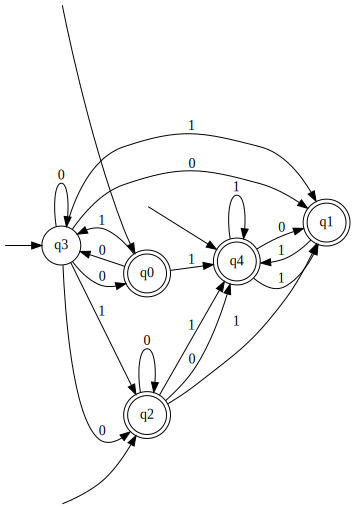

In [23]:
instantiate_nfa(df.loc[250]).plot()

In [51]:
df["rel_error_over_eps"] = df.rel_error / df.eps

In [62]:
df.sort_values(by="rel_error_over_eps", ascending=False).head(20)

,n_states,initial_states,final_states,transitions,string_n,bruteforce,estimate,eps,time,rel_error,rel_error_over_eps
250,5,"{q0, q4, q2, q3}","{q0, q4, q1, q2}","{'q0': {'1': {'q4', 'q3'}, '0': {'q3'}}, 'q1':...",14,6256,346126.976953,28,5106.766545,54.327202,1.940257
97,6,"{q0, q4, q1}","{q0, q1, q2, q3}","{'q0': {'0': {'q5', 'q1'}, '1': {'q5', 'q2', '...",5,32,348.516394,8,141.583673,9.891137,1.236392
155,5,"{q0, q1, q3}","{q4, q2}","{'q0': {'0': {'q0', 'q2'}, '1': {'q4'}}, 'q1':...",14,16384,910667.905438,54,3016.351845,54.582758,1.010792
57,6,"{q0, q1}","{q4, q2, q5, q0, q3}","{'q0': {'1': {'q5', 'q3'}, '0': {'q5', 'q4', '...",5,32,237.365394,8,75.338577,6.417669,0.802209
45,5,{q4},"{q4, q1, q2}","{'q0': {'1': {'q1'}, '0': {'q1'}}, 'q1': {'0':...",10,1024,12388.688906,15,1348.562958,11.098329,0.739889
185,4,{q3},"{q2, q3}","{'q0': {'1': {'q1'}, '0': {'q1', 'q2', 'q3'}},...",10,1024,25935.479221,43,391.159397,24.327616,0.565759
248,5,"{q0, q3}",{q4},"{'q0': {'1': {'q0', 'q4', 'q3'}, '0': {'q1', '...",10,1024,8786.812229,21,1189.039953,7.580871,0.360994
317,7,{q5},"{q5, q0, q6}","{'q0': {'0': {'q1', 'q2'}}, 'q1': {'1': {'q0',...",7,128,1902.533180,43,194.612001,13.863540,0.322408
93,5,"{q0, q4, q1}","{q4, q3}","{'q0': {'1': {'q2', 'q3'}}, 'q1': {'0': {'q1'}...",7,128,389.541770,7,484.051723,2.043295,0.291899
135,5,"{q0, q2}","{q0, q4, q3}","{'q0': {'0': {'q4', 'q1', 'q2', 'q3'}}, 'q1': ...",6,64,455.550164,22,51.058338,6.117971,0.278090


In [54]:
nfa = instantiate_nfa(df.loc[97])

In [ ]:
nfa.plot()

In [23]:
nfa.transitions

In [30]:
nfa.final_states

{'q0', 'q1', 'q4'}

In [5]:
def random_nfa_stats():
    n_states = randint(2, 14)
    sparsity = random() / 2 + 0.5
    n_initial = randint(1, n_states)
    n_final = randint(1, n_states)
    r = random_matrix_for_nfa(n_states=n_states, sparsity=sparsity, n_initial=n_initial, n_final=n_final)
    nfa = NFA.from_random_matrix(r)
    accepting_count = [nfa.bruteforce_count_only(i) for i in range(1, 16)]
    height = nfa.cycle_height()

    return {
        "sparsity": sparsity,
        "matrix": r,
        "accepted_counts": accepting_count,
        "height": height
    }

In [51]:
samples = 0
errors = []
error_count = 0
n_proc = 6
timeout = 30
# results = []

with Pool(processes=n_proc) as pool:
    
    while error_count < 30:
        multiproc_results = [pool.apply_async(random_nfa_stats) for _ in range(100)]
        for res_promise in tqdm(multiproc_results):
            res = None
            try:
                res = res_promise.get(timeout=timeout)
            except TimeoutError:
                continue

            if isinstance(res, Exception):
                errors.append(res)
                error_count += 1
                continue
            else:
                samples += 1
                
                results.append(res)

        clear_output(wait=True)
        #with open("random_nfa_from_matrices.pkl", "wb") as fd:
        #    pickle.dump(results, fd)
        #print(f"Wrote pickle file for {len(results)} results")

Wrote pickle file for 5400 results
